# w261 Final Project - Clickthrough Rate Prediction


# Team & Members

Team #21

Brent Biseda  
Katie Mo  
Teddy Fong  
Thanh Le  
Summer 2019, section 4   

In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
import sys
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.functions as F
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import StandardScaler
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoderEstimator, OneHotEncoderModel
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, MinMaxScaler, MaxAbsScaler, Imputer, VectorAssembler, SQLTransformer
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
sc = SparkContext(appName="Final_Project")
sqlContext = SQLContext(sc)

# Add Column ID to testDF

In order to submit to Kaggle we should ensure that the correct id is appended to the dataframe prior to processing with spark as we may lose the ability to know which row id we are evaluating

In [5]:
start = time.time()
testDF = pd.read_csv("test.txt", delimiter="\t", header=None)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 28.57644557952881 seconds


In [6]:
testDF.insert(0, "id", np.arange(len(testDF)) + 60000000)

In [7]:
testDF = testDF.astype({"id": int})

In [8]:
start = time.time()
testDF.to_csv("test2.txt", sep="\t", index=False, header=False)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 75.1240165233612 seconds


# Write the CSV's to Parquet

In [9]:
def parseAllColumns(line):
    row = line.split("\t")
    for i in range(14):
        if row[i] == "":
            row[i] = None
        else:
            row[i] = float(row[i])

    return row

In [10]:
# Convert train file from csv to parquet
start = time.time()
schema = StructType([
    StructField("y", FloatType(), True),
    StructField("x1", FloatType(), True),
    StructField("x2", FloatType(), True),
    StructField("x3", FloatType(), True),
    StructField("x4", FloatType(), True),
    StructField("x5", FloatType(), True),
    StructField("x6", FloatType(), True),
    StructField("x7", FloatType(), True),
    StructField("x8", FloatType(), True),
    StructField("x9", FloatType(), True),
    StructField("x10", FloatType(), True),
    StructField("x11", FloatType(), True),
    StructField("x12", FloatType(), True),
    StructField("x13", FloatType(), True),
    StructField("x14", StringType(), True),
    StructField("x15", StringType(), True),
    StructField("x16", StringType(), True),
    StructField("x17", StringType(), True),
    StructField("x18", StringType(), True),
    StructField("x19", StringType(), True),
    StructField("x20", StringType(), True),
    StructField("x21", StringType(), True),
    StructField("x22", StringType(), True),
    StructField("x23", StringType(), True),
    StructField("x24", StringType(), True),
    StructField("x25", StringType(), True),
    StructField("x26", StringType(), True),
    StructField("x27", StringType(), True),
    StructField("x28", StringType(), True),
    StructField("x29", StringType(), True),
    StructField("x30", StringType(), True),
    StructField("x31", StringType(), True),
    StructField("x32", StringType(), True),
    StructField("x33", StringType(), True),
    StructField("x34", StringType(), True),
    StructField("x35", StringType(), True),
    StructField("x36", StringType(), True),
    StructField("x37", StringType(), True),
    StructField("x38", StringType(), True),
    StructField("x39", StringType(), True)])

rdd = sc.textFile('train.txt').map(parseAllColumns)
df = sqlContext.createDataFrame(rdd, schema)
df.write.parquet('train.parquet')
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 450.37015986442566 seconds


In [11]:
# Convert test file from csv to parquet
start = time.time()
schema = StructType([
    StructField("id", DoubleType(), True), # We Created an ID Label
    StructField("x1", FloatType(), True),
    StructField("x2", FloatType(), True),
    StructField("x3", FloatType(), True),
    StructField("x4", FloatType(), True),
    StructField("x5", FloatType(), True),
    StructField("x6", FloatType(), True),
    StructField("x7", FloatType(), True),
    StructField("x8", FloatType(), True),
    StructField("x9", FloatType(), True),
    StructField("x10", FloatType(), True),
    StructField("x11", FloatType(), True),
    StructField("x12", FloatType(), True),
    StructField("x13", FloatType(), True),
    StructField("x14", StringType(), True),
    StructField("x15", StringType(), True),
    StructField("x16", StringType(), True),
    StructField("x17", StringType(), True),
    StructField("x18", StringType(), True),
    StructField("x19", StringType(), True),
    StructField("x20", StringType(), True),
    StructField("x21", StringType(), True),
    StructField("x22", StringType(), True),
    StructField("x23", StringType(), True),
    StructField("x24", StringType(), True),
    StructField("x25", StringType(), True),
    StructField("x26", StringType(), True),
    StructField("x27", StringType(), True),
    StructField("x28", StringType(), True),
    StructField("x29", StringType(), True),
    StructField("x30", StringType(), True),
    StructField("x31", StringType(), True),
    StructField("x32", StringType(), True),
    StructField("x33", StringType(), True),
    StructField("x34", StringType(), True),
    StructField("x35", StringType(), True),
    StructField("x36", StringType(), True),
    StructField("x37", StringType(), True),
    StructField("x38", StringType(), True),
    StructField("x39", StringType(), True)])

rdd = sc.textFile('test2.txt').map(parseAllColumns)
df = sqlContext.createDataFrame(rdd, schema)
df.write.parquet('test.parquet')
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 63.724459171295166 seconds


In [5]:
# start Spark Session
app_name = "final_project_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()

In [6]:
spark

In [7]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [8]:
sc._conf.getAll()

[('spark.driver.memory', '25g'),
 ('spark.driver.port', '38519'),
 ('spark.app.name', 'final_project_notebook'),
 ('spark.app.id', 'local-1574524168976'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', 'docker.w261'),
 ('spark.executor.memory', '25g')]

In [113]:
testDF = sqlContext.read.parquet('test.parquet') 
trainDF = sqlContext.read.parquet('train.parquet')

In [114]:
HEADER = trainDF.columns
INTEGER_FEATURES = HEADER[0:14] # These are the integer features
CATEGORICAL_FEATURES = HEADER[14:] # These are the categorical features

In [69]:
sample = trainDF.sample(False, 0.001, seed=1234).toPandas() # Approximately 50000 records

In [70]:
sample.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39
0,0.0,0.0,4.0,168.0,NaN,19290.0,NaN,NaN,16.0,NaN,...,e5ba7672,f855e3f0,21ddcdc9,5840adea,54bf0a81,,be7c41b4,3371d710,001f3601,aa5f0a15
1,0.0,2.0,63.0,13.0,2.0,2.0,2.0,3.0,7.0,2.0,...,07c540c4,bc5a0ff7,04de9d96,a458ea53,93ecdb15,,32c7478e,80ad7846,001f3601,d43d2464
2,0.0,NaN,1.0,6.0,16.0,3801.0,23.0,12.0,17.0,129.0,...,e5ba7672,a673f1fe,,,0af6c332,,32c7478e,30b71e2c,,
3,0.0,3.0,19.0,37.0,4.0,622.0,45.0,35.0,15.0,270.0,...,3486227d,1f868fdd,4764bf77,a458ea53,50757f64,,32c7478e,a9d2466c,9d93af03,685f2dd2
4,0.0,0.0,1.0,6.0,5.0,1935.0,13.0,20.0,14.0,76.0,...,3486227d,e88ffc9d,cf99e5de,a458ea53,d8ad7a42,,423fab69,defc8ccf,cb079c2d,6867cdf2


In [71]:
sample.describe()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
count,45679.000000,25060.000000,45679.000000,35821.000000,35809.000000,4.451600e+04,35525.000000,43681.000000,45657.000000,43681.000000,25060.000000,43681.000000,10782.000000,35809.000000
mean,0.256048,3.549920,106.763702,26.597639,7.301488,1.866125e+04,121.979958,16.490259,12.511422,106.333328,0.620591,2.746412,1.071230,8.229635
std,0.436386,10.378813,392.868225,324.231537,8.671590,6.967927e+04,1037.525146,69.985497,13.848645,217.065140,0.684208,5.124965,5.548083,12.455992
min,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.000000,2.000000,3.240000e+02,8.000000,1.000000,2.000000,10.000000,0.000000,1.000000,0.000000,2.000000
50%,0.000000,1.000000,3.000000,6.000000,4.000000,2.803000e+03,33.000000,3.000000,7.000000,39.000000,1.000000,1.000000,0.000000,4.000000
75%,1.000000,3.000000,35.000000,18.000000,10.000000,1.014900e+04,103.000000,12.000000,19.000000,110.000000,1.000000,3.000000,1.000000,10.000000
max,1.000000,598.000000,7285.000000,25884.000000,161.000000,2.396848e+06,186387.000000,6328.000000,586.000000,9140.000000,7.000000,101.000000,142.000000,461.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7febe7242b50>,
      dtype=object)

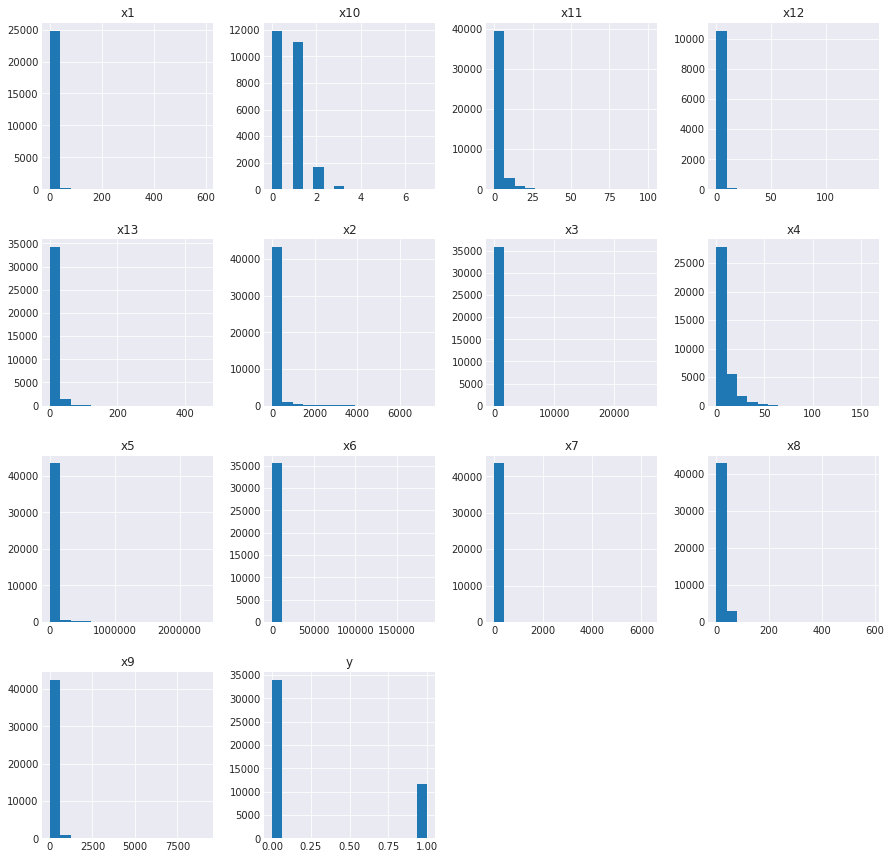

In [72]:
sample[INTEGER_FEATURES].hist(figsize=(15,15), bins=15)

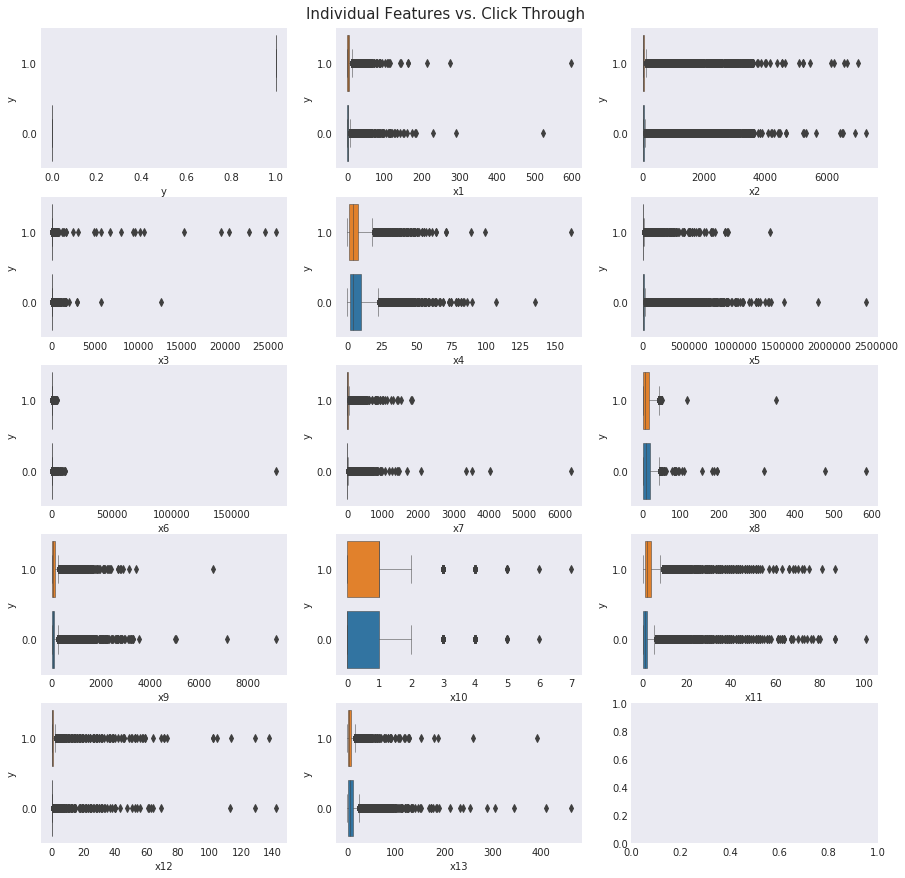

In [73]:
fig, ax_grid = plt.subplots(5, 3, figsize=(15,15))
y = sample['y']
for idx, feature in enumerate(INTEGER_FEATURES):
    x = sample[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("Individual Features vs. Click Through", fontsize=15, y=0.9)
plt.show()

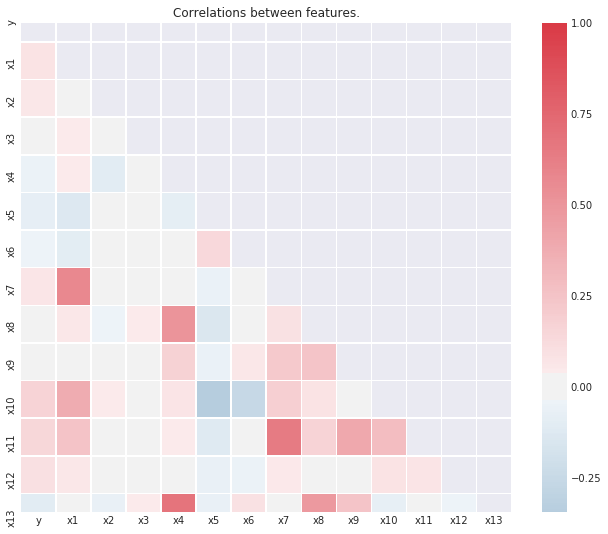

In [74]:
# plot heatmap for correlations matrix - RUN THIS CELL AS IS
corr = sample[INTEGER_FEATURES].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

# Multi-collinearity Concerns

Based on the graphic above, we see that a number of features are correlated with one another.  We see that X4 is correlated to X13, X4 is also somewhat correlated to X8.  X7 is correlated to X11, and X8 is correlated to X13.  From this view, we can make the decision to eliminate X13, X11, and X4 from this analysis because of the condition of no multi-collinearity when using logistic regression.

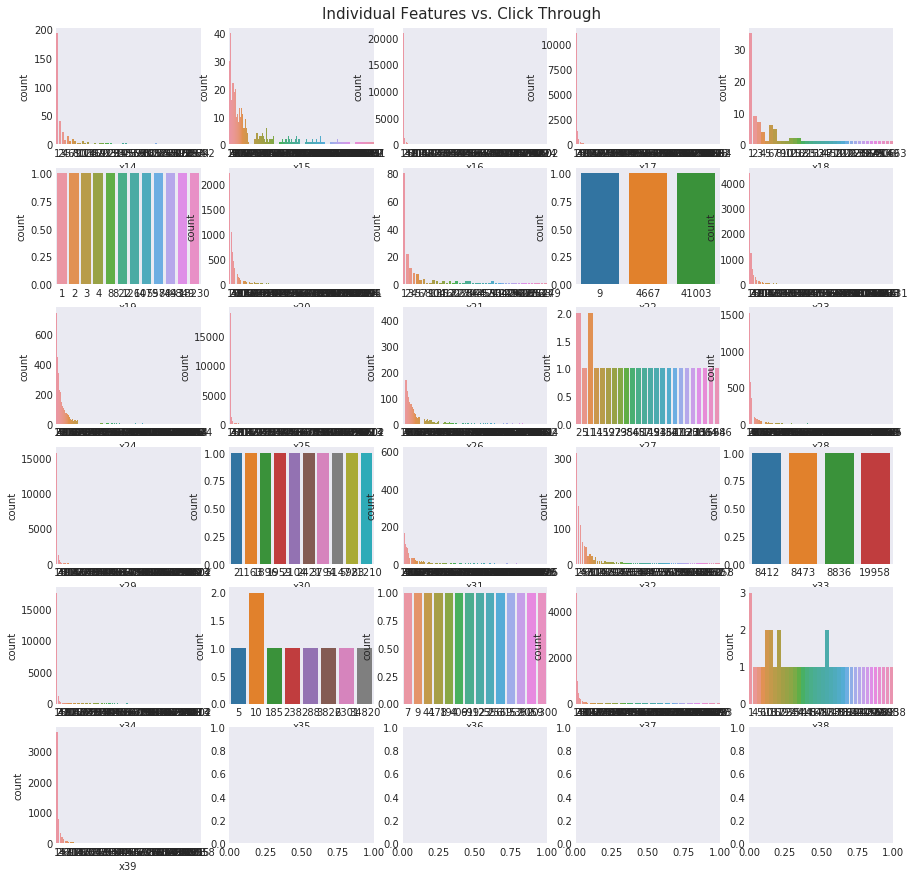

In [75]:
# Categorical Data Visualization
fig, ax_grid = plt.subplots(6, 5, figsize=(15,15))
for idx, feature in enumerate(CATEGORICAL_FEATURES):
    x = sample[feature].astype('category').value_counts()
    sns.countplot(x, ax=ax_grid[idx//5][idx%5], linewidth=.5)
fig.suptitle("Individual Features vs. Click Through", fontsize=15, y=0.9)
plt.show()

In [115]:
# Count Number of Unique Values
start = time.time()
distinct = []
for col in CATEGORICAL_FEATURES:
    distinct.append(set(trainDF.select(col).distinct().rdd.map(lambda x: x[0]).collect()))
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 181.4345474243164 seconds


In [116]:
for item, number in zip(CATEGORICAL_FEATURES, distinct):
    print(f"Feature: {item} had {len(number)} unique values")

Feature: x14 had 1460 unique values
Feature: x15 had 583 unique values
Feature: x16 had 10131227 unique values
Feature: x17 had 2202608 unique values
Feature: x18 had 305 unique values
Feature: x19 had 24 unique values
Feature: x20 had 12517 unique values
Feature: x21 had 633 unique values
Feature: x22 had 3 unique values
Feature: x23 had 93145 unique values
Feature: x24 had 5683 unique values
Feature: x25 had 8351593 unique values
Feature: x26 had 3194 unique values
Feature: x27 had 27 unique values
Feature: x28 had 14992 unique values
Feature: x29 had 5461306 unique values
Feature: x30 had 10 unique values
Feature: x31 had 5652 unique values
Feature: x32 had 2173 unique values
Feature: x33 had 4 unique values
Feature: x34 had 7046547 unique values
Feature: x35 had 18 unique values
Feature: x36 had 15 unique values
Feature: x37 had 286181 unique values
Feature: x38 had 105 unique values
Feature: x39 had 142572 unique values


From the Above we should probably exclude the features with too many unique values to be able to generalize the data:  
x16, x17, x25, x29, x34, and x37.  If we have memory issues we can try excluding x39 and x23, which will also have large numbers of one hot encodings.

In order to preserve some aspect of this data, we can instead keep the top K values for these specific columns in order to continue to use them in our model.  We will perform this transformation for these specific variables.

In [117]:
featuresToDrop = set()
featuresToDrop.add('x4')
featuresToDrop.add('x11')
featuresToDrop.add('x13')

In [118]:
def keepTopK(df, dftest, K, categoricalColumnstoImpute):
    for col in categoricalColumnstoImpute:
        mostCommon = df.select(col).groupby(col).count()\
                            .orderBy('count', ascending=False) \
                            .limit(K).collect()
            
        mostCommonSet = set([x[0] for x in mostCommon])
               
        df = df.withColumn(col, F.when(~df[col].isin(mostCommonSet), "RECODED").otherwise(df[col]))
        
        dftest = dftest.withColumn(col, F.when(~dftest[col].isin(mostCommonSet), "RECODED") \
                        .otherwise(dftest[col]))
    
    print("Successfully Recoded Top K Categorical Values")
    
    return (df, dftest)

In [119]:
# start = time.time()
# trainDF, testDF = keepTopK(trainDF, testDF, 10, ['x16', 'x17', 'x25', 'x29', 'x34', 'x37'])
# print(f"\n... Executed in {time.time() - start} seconds")

In [120]:
start = time.time()
trainDF, testDF = keepTopK(trainDF, testDF, 100, CATEGORICAL_FEATURES)
print(f"\n... Executed in {time.time() - start} seconds")

Successfully Recoded Top K Categorical Values

... Executed in 100.38571691513062 seconds


# Now We Check Our Categorical Counts Again To Verify that we Recoded Our Selected Columns

In [121]:
# Count Number of Unique Values
start = time.time()
distinct = []
for col in CATEGORICAL_FEATURES:
    distinct.append(set(trainDF.select(col).distinct().rdd.map(lambda x: x[0]).collect()))
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 154.48245477676392 seconds


In [122]:
for item, number in zip(CATEGORICAL_FEATURES, distinct):
    print(f"Feature: {item} had {len(number)} unique values")

Feature: x14 had 101 unique values
Feature: x15 had 101 unique values
Feature: x16 had 101 unique values
Feature: x17 had 101 unique values
Feature: x18 had 101 unique values
Feature: x19 had 24 unique values
Feature: x20 had 101 unique values
Feature: x21 had 101 unique values
Feature: x22 had 3 unique values
Feature: x23 had 101 unique values
Feature: x24 had 101 unique values
Feature: x25 had 101 unique values
Feature: x26 had 101 unique values
Feature: x27 had 27 unique values
Feature: x28 had 101 unique values
Feature: x29 had 101 unique values
Feature: x30 had 10 unique values
Feature: x31 had 101 unique values
Feature: x32 had 101 unique values
Feature: x33 had 4 unique values
Feature: x34 had 101 unique values
Feature: x35 had 18 unique values
Feature: x36 had 15 unique values
Feature: x37 had 101 unique values
Feature: x38 had 101 unique values
Feature: x39 had 101 unique values


In [123]:
distinctDict = dict((k, v) for k, v  in zip(CATEGORICAL_FEATURES, distinct))

# We Will Need to Impute Values rather than Filling with 0's

Here we will impute the mean for missing values for numerical features.  In the case of categorical features, we will impute the most common instance for that categorical feature.  If the most common feature is a missing value, we will create a new "empty" variable that will hold the place for this circumstance.  In the case that the test data has unseen categorical values, we will replace those with the empty string and allow the impute function to fill these values.

In [124]:
def imputeValues(df, dftest):
    categoricalColumnstoImpute = [col for col in CATEGORICAL_FEATURES if col not in featuresToDrop]
    
    # Impute numerical features
    for col in INTEGER_FEATURES[1:]:
        mean = df.select(col).agg({col:'mean'}).collect()[0][0]
        print(f"Column {col} has mean {mean}")
        df = df.withColumn(col, F.when(df[col].isNull(), mean).otherwise(df[col]))
        dftest = dftest.withColumn(col, F.when(dftest[col].isNull(), mean).otherwise(dftest[col]))
    print("Successfully Imputed Numerical Values")

    # Impute categorical features
    for col in categoricalColumnstoImpute:
        mostCommon = df.select(col).groupby(col).count()\
                            .orderBy('count', ascending=False) \
                            .limit(1).collect()[0][0]
        if mostCommon == "":
            mostCommon = "EMPTY"
        
        print(f"Column {col} has most common {mostCommon}")
        
        df = df.withColumn(col, F.when((df[col].isNull() | (df[col] == '')), mostCommon) \
                                .otherwise(df[col]))
        
        dftest = dftest.withColumn(col, F.when((dftest[col].isNull() | (dftest[col] == '') | (~dftest[col].isin(distinctDict[col]))), mostCommon) \
                        .otherwise(dftest[col]))
    print("Successfully Imputed Categorical Values")
    
    # Assure there is no missing values
    for col in INTEGER_FEATURES[1:] + categoricalColumnstoImpute:
        assert df.filter(df[col].isNull()).count() == 0, f"Column {col} contains NULL value(s)"
        assert df.filter(df[col] == '').count() == 0, f"Column {col} contains empty string(s)"
    
        assert dftest.filter(dftest[col].isNull()).count() == 0, f"Column {col} contains NULL value(s)"
        assert dftest.filter(dftest[col] == '').count() == 0, f"Column {col} contains empty string(s)"
    
    print("Successfully Imputed All Values and Passed Tests")
    return (df, dftest)

In [125]:
start = time.time()
trainDF, testDF = imputeValues(trainDF, testDF)
print(f"\n... Executed in {time.time() - start} seconds")

Column x1 has mean 3.5024133170754044
Column x2 has mean 105.84841979766546
Column x3 has mean 26.913041020611274
Column x4 has mean 7.322680248873305
Column x5 has mean 18538.991664871523
Column x6 has mean 116.06185085211598
Column x7 has mean 16.333130032135028
Column x8 has mean 12.517042137556713
Column x9 has mean 106.1098234380509
Column x10 has mean 0.6175294977722137
Column x11 has mean 2.7328343170173044
Column x12 has mean 0.9910356287721244
Column x13 has mean 8.217461161174054
Successfully Imputed Numerical Values
Column x14 has most common 05db9164
Column x15 has most common RECODED
Column x16 has most common RECODED
Column x17 has most common RECODED
Column x18 has most common 25c83c98
Column x19 has most common 7e0ccccf
Column x20 has most common RECODED
Column x21 has most common 0b153874
Column x22 has most common a73ee510
Column x23 has most common RECODED
Column x24 has most common RECODED
Column x25 has most common RECODED
Column x26 has most common RECODED
Column 

We then write these new files to parquet so that we do not need to execute these commands in our future analysis in the case of our machine crashing.

In [126]:
start = time.time()
trainDF.write.parquet('trainImputed.parquet')
testDF.write.parquet('testImputed.parquet')
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 456.99630641937256 seconds


In [127]:
start = time.time()
trainDF = sqlContext.read.parquet('trainImputed.parquet')
testDF = sqlContext.read.parquet('testImputed.parquet')
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.06833910942077637 seconds


In [128]:
start = time.time()

assembler = VectorAssembler(inputCols = [feature for feature in INTEGER_FEATURES if feature not in featuresToDrop][1:], outputCol = 'integerFeatures')
trainDF = assembler.transform(trainDF)
testDF = assembler.transform(testDF)

print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.04037213325500488 seconds


In [129]:
featuresToDrop = featuresToDrop.union(set(INTEGER_FEATURES[1:]))

In [130]:
# Drop the Integer Columns
trainDF = trainDF.select([c for c in trainDF.columns if c not in featuresToDrop])
testDF = testDF.select([c for c in testDF.columns if c not in featuresToDrop])

# Now we Will Apply One Hot Encoding and Scale Our Features for Use With Regularization

In [131]:
OHE_CATEGORICAL_FEATURES =  set(CATEGORICAL_FEATURES)-featuresToDrop # Remaining Categorical Features for the One hot encoding

In [132]:
# Based on Code from: https://chih-ling-hsu.github.io/2018/09/17/spark-mllib

def makePreprocessor(df):
    # String Indexing for categorical features
    indexers = [StringIndexer(inputCol=col, 
                              outputCol="{}_idx".format(col)) \
                              for col in OHE_CATEGORICAL_FEATURES]
    
    # One-hot encoding for categorical features
    encoders = [OneHotEncoder(inputCol="{}_idx".format(col), 
                              outputCol="{}_oh".format(col)) \
                              for col in OHE_CATEGORICAL_FEATURES]

    # Concat Feature Columns
    assembler = VectorAssembler(inputCols = ["integerFeatures"] + \
                            ["{}_oh".format(col) for col in OHE_CATEGORICAL_FEATURES], 
                            outputCol = "scaledFeatures")
     # Scale Features
    scaler = MaxAbsScaler(inputCol='scaledFeatures', 
                            outputCol='features')
    
    preprocessor = Pipeline(stages = indexers + encoders + [assembler, scaler]).fit(df)

    return preprocessor

In [133]:
start = time.time()
# Pre-Process All Training Data
preprocessor = makePreprocessor(trainDF)   
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 357.3689579963684 seconds


In [134]:
start = time.time()
trainDF = preprocessor.transform(trainDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.39841628074645996 seconds


In [135]:
start = time.time()
testDF = preprocessor.transform(testDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.42321062088012695 seconds


We will now drop all the features except for what we will use in our model 

In [136]:
OHE_CATEGORICAL_FEATURES_idx = [f"{col}_idx" for col in OHE_CATEGORICAL_FEATURES]
OHE_CATEGORICAL_FEATURES_oh = [f"{col}_oh" for col in OHE_CATEGORICAL_FEATURES]

featuresToDrop = featuresToDrop.union(set(OHE_CATEGORICAL_FEATURES))\
                                .union(set(OHE_CATEGORICAL_FEATURES_idx))\
                                .union(set(OHE_CATEGORICAL_FEATURES_oh))
featuresToDrop.add('scaledFeatures')
featuresToDrop.add('integerFeatures')

In [137]:
# Drop the Other Feature Columns We Will Not Use
trainDF = trainDF.select([c for c in trainDF.columns if c not in featuresToDrop])
testDF = testDF.select([c for c in testDF.columns if c not in featuresToDrop])

### Now we can write to a parquet File so that we should only need to work on our model now

In [138]:
start = time.time()
trainDF.write.parquet('train_for_model.parquet')
testDF.write.parquet('test_for_model.parquet')
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 435.3749771118164 seconds


# Now We can Load our Parquet as a checkpoint and Will Evaluate Using Logistic Regression with A Grid Search

In [139]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
import sys
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.functions as F
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import StandardScaler, MinMaxScaler, MaxAbsScaler
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoderEstimator, OneHotEncoderModel
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, Imputer, VectorAssembler, SQLTransformer
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

In [140]:
# start Spark Session
app_name = "final_project_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()

In [141]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [142]:
start = time.time()
trainDF = sqlContext.read.parquet('train_for_model.parquet')
testDF = sqlContext.read.parquet('test_for_model.parquet')
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.06791448593139648 seconds


In [143]:
# Generate 80/20 (pseudo)random train/test split 
start = time.time()
trainDF, validDF = trainDF.randomSplit([0.8,0.2], seed = 1)
print(f"Assigned {trainDF.count()} for training. Assigned {validDF.count()} for Validation.")
print(f"\n... Executed in {time.time() - start} seconds")

Assigned 36672829 for training. Assigned 9167788 for Validation.

... Executed in 195.44548678398132 seconds


In [167]:
start = time.time()
lr = LogisticRegression(featuresCol = 'features', labelCol='y', maxIter=1000, regParam=1.5)
lr_model = lr.fit(trainDF)
lr_train_predictions = lr_model.transform(trainDF)
lr_valid_predictions = lr_model.transform(validDF)
lr_test_predictions = lr_model.transform(testDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 302.21872544288635 seconds


In [168]:
start = time.time()
lr_evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction",metricName="areaUnderPR")

trainAUPR = lr_evaluator.evaluate(lr_train_predictions)
validAUPR = lr_evaluator.evaluate(lr_valid_predictions)
print(f"Area Under Precision Recall Curve on Train data = {trainAUPR}")
print(f"Area Under Precision Recall Curve on Validation data = {validAUPR}")
print(f"\n... Executed in {time.time() - start} seconds")

Area Under Precision Recall Curve on Train data = 0.511454730430641
Area Under Precision Recall Curve on Validation data = 0.5118248954406841

... Executed in 220.62927985191345 seconds


# Trying a Random Forest

In [146]:
from pyspark.ml.classification import RandomForestClassifier

In [150]:
start = time.time()
rf = RandomForestClassifier(labelCol="y", featuresCol="features", numTrees=100)
rf_model = rf.fit(trainDF)
rf_train_predictions = rf_model.transform(trainDF)
rf_valid_predictions = rf_model.transform(validDF)
rf_test_predictions = rf_model.transform(testDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 13551.50096321106 seconds


In [151]:
start = time.time()
rf_evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction",metricName="areaUnderPR")

trainAUPR = rf_evaluator.evaluate(rf_train_predictions)
validAUPR = rf_evaluator.evaluate(rf_valid_predictions)
print(f"Area Under Precision Recall Curve on Train data = {trainAUPR}")
print(f"Area Under Precision Recall Curve on Validation data = {validAUPR}")
print(f"\n... Executed in {time.time() - start} seconds")

Area Under Precision Recall Curve on Train data = 0.2562232381908688
Area Under Precision Recall Curve on Validation data = 0.25622396591195173

... Executed in 1131.6167435646057 seconds


# Trying a Gradient Boosted Tree

In [154]:
from pyspark.ml.classification import GBTClassifier

In [155]:
start = time.time()
gbt = GBTClassifier(labelCol="y", featuresCol="features", maxIter=100)
gbt_model = gbt.fit(trainDF)
gbt_train_predictions = gbt_model.transform(trainDF)
gbt_valid_predictions = gbt_model.transform(validDF)
gbt_test_predictions = gbt_model.transform(testDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 195144.54537200928 seconds


In [156]:
start = time.time()
gbt_evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction",metricName="areaUnderPR")

trainAUPR = gbt_evaluator.evaluate(gbt_train_predictions)
validAUPR = gbt_evaluator.evaluate(gbt_valid_predictions)
print(f"Area Under Precision Recall Curve on Train data = {trainAUPR}")
print(f"Area Under Precision Recall Curve on Validation data = {validAUPR}")
print(f"\n... Executed in {time.time() - start} seconds")

Area Under Precision Recall Curve on Train data = 0.4945870670790396
Area Under Precision Recall Curve on Validation data = 0.49410177103923014

... Executed in 372.9572768211365 seconds


In [158]:
start = time.time()
gbt_model.save("gbt_best_model")
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.7956719398498535 seconds


# K Fold Cross Validation

In [41]:
start = time.time()
lr = LogisticRegression(featuresCol = 'features', labelCol='y', maxIter=100)
    
# Train the 10-fold Cross Validator
cvModel = CrossValidator(estimator=Pipeline(stages = [lr]),
            estimatorParamMaps=ParamGridBuilder() \
                                .addGrid(lr.regParam, [1.5, 1.0, 0.5]) \
                                .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.5, 0.8, 1.0]) \
                                .build(),
            evaluator=BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction",metricName="areaUnderPR"),numFolds=10).fit(trainDF)

print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 18905.01717185974 seconds


In [42]:
regParam = cvModel.bestModel.stages[-1]._java_obj.getRegParam()
maxIter = cvModel.bestModel.stages[-1]._java_obj.getMaxIter()
elasticNetParam = cvModel.bestModel.stages[-1]._java_obj.getElasticNetParam()
print("Best Model Parameters:")
print(f"Reg Param: {regParam}, Max Iterations: {maxIter}, Elastic Net Param: {elasticNetParam}")

Best Model Parameters:
Reg Param: 1.5, Max Iterations: 100, Elastic Net Param: 0.0


After running the logistic regression grid search, from the selected parameters we saw the best model using a regularization parameter of 1.5, and an elastic net parameter of 0.  We can continue to refine our regularization parameter by running another grid search over a smaller area.

In [44]:
start = time.time()
lr = LogisticRegression(featuresCol = 'features', labelCol='y', maxIter=100)
    
# Train the 10-fold Cross Validator
cvModel = CrossValidator(estimator=Pipeline(stages = [lr]),
            estimatorParamMaps=ParamGridBuilder() \
                                .addGrid(lr.regParam, [2.0, 1.75, 1.50, 1.25, 1.0]) \
                                .build(),
            evaluator=BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction",metricName="areaUnderPR"),numFolds=10).fit(trainDF)

print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 19242.73370909691 seconds


In [45]:
regParam = cvModel.bestModel.stages[-1]._java_obj.getRegParam()
maxIter = cvModel.bestModel.stages[-1]._java_obj.getMaxIter()
elasticNetParam = cvModel.bestModel.stages[-1]._java_obj.getElasticNetParam()
print("Best Model Parameters:")
print(f"Reg Param: {regParam}, Max Iterations: {maxIter}, Elastic Net Param: {elasticNetParam}")

Best Model Parameters:
Reg Param: 1.5, Max Iterations: 100, Elastic Net Param: 0.0


Now we select our model parameters and train with a much higher maximum iteration

In [46]:
start = time.time()
lr = LogisticRegression(featuresCol = 'features', labelCol='y', regParam=1.5, maxIter=10**4)
    
# Train the 10-fold Cross Validator
cvModel = CrossValidator(estimator=Pipeline(stages = [lr]),
            estimatorParamMaps=ParamGridBuilder() \
                                .build(),
            evaluator=BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction",metricName="areaUnderPR"),numFolds=10).fit(trainDF)

print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 4579.929152011871 seconds


In [47]:
start = time.time()
cvModel.bestModel.save("best_model")
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.5130650997161865 seconds


## Load The Best Model

In [48]:
# start = time.time()
# cvModel = PipelineModel.load("best_model")
# print(f"\n... Executed in {time.time() - start} seconds")

In [49]:
start = time.time()
trainPredsAndLabels = cvModel.transform(trainDF)
validPredsAndLabels = cvModel.transform(validDF)
testPredsAndLabels = cvModel.transform(testDF)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.04922294616699219 seconds


# Evaluate Our Best Model with Selected Metrics

In [50]:
def evaluateModel(predictionAndLabels):
    
    resultsDict = dict()
    
    # Area Under ROC
    evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction", metricName="areaUnderROC")
    areaUnderROC = evaluator.evaluate(predictionAndLabels)    
    print(f"Area under ROC = {areaUnderROC}")
    resultsDict['areaUnderROC'] = areaUnderROC

    # Area Under PR
    evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="prediction", metricName='areaUnderPR')
    areaUnderPR = evaluator.evaluate(predictionAndLabels)
    print(f"Area under PR = {areaUnderPR}")
    resultsDict['areaUnderPR'] = areaUnderPR

    # Metrics
    predictionRDD = predictionAndLabels.select(['y', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)

    # Confusion Matrix
    print(metrics.confusionMatrix().toArray())

    # Overall statistics
    precision = metrics.precision()
    resultsDict['precision'] = precision
    
    recall = metrics.recall()
    resultsDict['recall'] = recall
    
    fscore = metrics.fMeasure()
    resultsDict['F Score'] = fscore
        
    print(f"Precision: {precision}, Recall: {recall}, F Score: {fscore}")
            
    # Statistics by class
    labels = [0.0, 1.0]
    for label in sorted(labels):
        resultsDict[label] = {}
        resultsDict[label]['precision'] = metrics.precision(label)
        resultsDict[label]['recall'] = metrics.recall(label)
        resultsDict[label]['F1 Measure'] = metrics.fMeasure(label, beta=1.0)
        print(f"Class {label}: Precision: {resultsDict[label]['precision']}, Recall: {resultsDict[label]['recall']}, F Score: {resultsDict[label]['F1 Measure']}")

    return resultsDict

In [51]:
start = time.time()
trainResultDict = evaluateModel(trainPredsAndLabels)
print(f"\n... Executed in {time.time() - start} seconds")

Area under ROC = 0.5023005049812859
Area under PR = 0.5525173873121492
[[2.7265708e+07 8.4040000e+03]
 [9.3506260e+06 4.6130000e+04]]
Precision: 0.7447829705039979, Recall: 0.7447829705039979, F Score: 0.7447829705039979
Class 0.0: Precision: 0.7446323818217302, Recall: 0.9996918689781724, F Score: 0.853514404955007
Class 1.0: Precision: 0.8458943044706055, Recall: 0.004909140984399297, F Score: 0.009761630422936974

... Executed in 880.9691870212555 seconds


In [52]:
start = time.time()
validResultDict = evaluateModel(validPredsAndLabels)
print(f"\n... Executed in {time.time() - start} seconds")

Area under ROC = 0.5023006916859679
Area under PR = 0.5505664548812527
[[6.818901e+06 2.166000e+03]
 [2.337129e+06 1.155300e+04]]
Precision: 0.7448899637274695, Recall: 0.7448899637274695, F Score: 0.7448899637274695
Class 0.0: Precision: 0.7447442832756118, Recall: 0.9996824543726077, F Score: 0.8535844778309852
Class 1.0: Precision: 0.8421167723595014, Recall: 0.004918928999328134, F Score: 0.009780727319367034

... Executed in 646.3143575191498 seconds


# Now We Can Visualize our Precision & Recall Graphs

Exception ignored in: <function JavaWrapper.__del__ at 0x7febf312cf80>
Traceback (most recent call last):
  File "/opt/anaconda/lib/python3.7/site-packages/pyspark-2.4.4-py3.7.egg/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'MaxAbsScaler' object has no attribute '_java_obj'


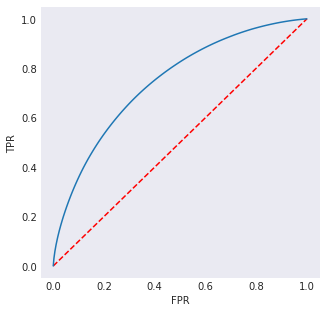


... Executed in 205.796049118042 seconds


In [53]:
start = time.time()
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(cvModel.bestModel.stages[-1].summary.roc.select('FPR').collect(),
         cvModel.bestModel.stages[-1].summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
print(f"\n... Executed in {time.time() - start} seconds")

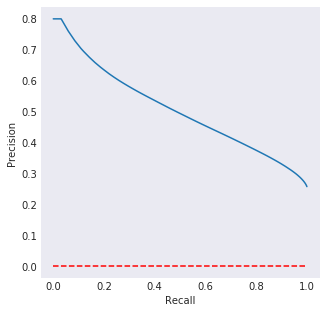


... Executed in 0.1961524486541748 seconds


In [54]:
start = time.time()
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 0], 'r--')
plt.plot(cvModel.bestModel.stages[-1].summary.pr.select('recall').collect(),
         cvModel.bestModel.stages[-1].summary.pr.select('precision').collect())
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
print(f"\n... Executed in {time.time() - start} seconds")

# Submit Our Test Set to Kaggle To See Performance

In [55]:
kaggleOutput = testPredsAndLabels.select(["id", "probability"])
kaggleOutput = kaggleOutput.rdd.map(lambda x: (int(x['id']), float(x['probability'][1])))

In [169]:
# Test Some Brief Stuff

kaggleOutput = lr_test_predictions.select(["id", "probability"])
kaggleOutput = kaggleOutput.rdd.map(lambda x: (int(x['id']), float(x['probability'][1])))

In [170]:
# Convert train file from csv to parquet
start = time.time()
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("probability", FloatType(), True)])

kaggleDF = sqlContext.createDataFrame(kaggleOutput, schema)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.05407404899597168 seconds


In [171]:
start = time.time()
kaggleDF.write.parquet('kaggle.parquet')
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 42.62530779838562 seconds


In [172]:
start = time.time()
kaggleDF = sqlContext.read.parquet('kaggle.parquet')
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 0.035701751708984375 seconds


In [173]:
start = time.time()
pandasDF = kaggleDF.toPandas()
pandasDF.columns=['id','Predicted']
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 14.604223251342773 seconds


In [174]:
start = time.time()
pandasDF.to_csv('submission.csv', header=True, index=False)
print(f"\n... Executed in {time.time() - start} seconds")


... Executed in 11.946702718734741 seconds


In [175]:
# !kaggle competitions list

In [176]:
!kaggle competitions submit -c criteo-display-ad-challenge -f submission.csv -m "Baseline Submission"

100%|████████████████████████████████████████| 114M/114M [01:40<00:00, 1.19MB/s]
Successfully submitted to Display Advertising Challenge

# Comparison between CSV & Parquet

Apache parquet file format is designed to more efficiently store columnar data rather than by row such as using a file format like csv.  Parquet is optimized to minimize file I/O and efficiently compresses.  Parquet can be queried more efficiently with SQL than csv files.  When using a cloud platform, users may be charged by I/O so use of a csv will be more expensive when compared to parquet.  Additionally, because parquet is faster, computation charges are correspondingly lower as well.  Parquet file format may yield a performance improvement around 10x, or an order of magnitude, when compared to performance on a csv.

Additionally, parquet file format allows for easy use of a spark DF as it has performance improvements relative to RDD.  

https://dzone.com/articles/how-to-be-a-hero-with-powerful-parquet-google-and  
https://developer.ibm.com/hadoop/2016/01/14/5-reasons-to-choose-parquet-for-spark-sql/  
https://mapr.com/blog/tips-and-best-practices-to-take-advantage-of-spark-2-x/  

# What is Evaluation Metric and how does this matter wrt over & under sampling?

Accuracy is not a good measure for this dataset because it is not balanced.  If we were to always predict that the user would not click on the advertisement, we would score a high accuracy because that is the predominant class.  There are some methods to deal with this aspect of the data, such as undersampling or oversampling, however, we were instructed that the dataset has already been resampled.  Accuracy is a good metric only if the data is uniformly distributed.  Therefore, we must choose other metrics in order to evaluate the performance of our model.  

Precision and recall are other metrics that we should consider.

$$ Precision = \frac{True Positives}{True Positives + False Positives}$$

$$ Recall = \frac{True Positives}{True Positives + False Negatives}$$

$$ F_1Score = 2\frac{Precision * Recall}{Precision + Recall}$$

Precision describes how well we are able to identify the true class.  As an example, a very high precision score occurs when there are few false positives.  A high precision score would occur if we correctly identify when people click on the add, but we may be missing many of the other clicks but we have very few false positives.

Recall describes how well we identify all of the positive class examples.  A high recall score occurs when we identify all of the clicks.  In this case, if we were to identify all ads as being clicked on, we would have a perfect Recall score, but have a very low precision.

The F score is the harmonic mean of Precision & Recall and can serve as a good metric to understand the trade-off between Precision & Recall.

![Under Sampling](support/under_sampling.png)

There are two other metrics that are also useful for us to evaluate the performance of our model: The ROC Curve, and the Precision-Recall Curve.  

The ROC (Receiver Operating Characteristic) Curve is a plot that shows the False Positive Rate on the X-axis, and the True Positive Rate on the y-axis.  The score is defined as the area under the curve.  It assists in the use of defining a threshold by which we can define our model.  We can tune the threshold to determine how many false positives we can tolerate in order to increase the number of true positives that we capture.  As an example, we could focus more effort and advertisement dollars on the individuals that we are very confident that they will click.

Similarly, the precision-recall curve plots recall along the X-axis with precision along the y-axis.  The score is defined as the area under the curve.  Just like with the ROC, we can tune our model by adjusting our recall to determine what precision we would accept.  

We ultimately use the area under the precision-recall curve in order to optimize our model.  This is well suited to deal with an imbalanced data set.

http://www.davidsbatista.net/blog/2018/08/19/NLP_Metrics/  
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/  

# Algorithm Explanation

When predicting click-through rate (CTR) for a website, our goal is to generate a probability value that is representative of a binary outcome.  Logistic regression is an algorithm that is particularly useful for this task.  That is, we are trying to predict if a user will click on an advertisement or not, we are defining a binary statistic with a probability between 0 and 1.  

The logistic model is useful as it better able to capture the shape of the probability distribution when compared to other methods such as linear regression.  Logistic regression always creates an S-shaped curve, which, cannot be below 0% or above 100% liklihood, in comparison to linear regression.  

Additionally, logistic regression does not have the same rigid assumptions that linear regression may have, and does not require us to scale our data.  However, because we choose to use regularization, we **do** indeed need to scale our features.  We may use the MaxAbsScaler because it is able to preserve sparsity.  Both standard scaler and min max scaler, produce dense outputs if we choose to center the mean.  

The assumptions for logistic regression are shown below:  

1. The dependent variable is binary
2. Observations are independent 
3. No multi-collinearity between independent variables
4. Independent variables are related to the log odds

From the above, we are confident that conditions 1 and 2 are satisfied.  Based on our EDA and the independent variables that we eliminated, we can be reasonably confident that condition 3 is also satisfied.  The fourth condition is a reasonable expectation in order to fit a model to the available data.  

The Logistic Regression Equation with Regularization is Shown Below:

$$ p(X) = \frac{e^{\sum_{i=0}^{n}\beta_iX}}{1+e^{\sum_{i=0}^{n}\beta_iX}}$$

$$ min \sum_{i=1}^L(log(1+exp(-y_i\theta))+\frac{\lambda}{2}||w||^2$$

Gareth, James. et al. An Introduction to Statistical Learning with Applications in R.  Springer Publishing.  2015.  
https://en.wikipedia.org/wiki/Logistic_regression  
http://www.cs.rpi.edu/~magdon/courses/LFD-Slides/SlidesLect09.pdf  

# Gradient Descent for Logistic Regression

Because the data is large, we cannot solve the parameters for the ideal regressor directly.  Instead, we must apply an algorithm to optimize the loss function.  A common method of optimizing the function is through the use of gradient descent.  That is, we iteratively evaluate points from our dataset then use these to gradually update the parameters of our model.  The mathematical detail to explain the application of this for logistic regression is shown below.

Our rows of data with dependent and independent variables are defined as:  

$$ y = \theta_0 + \theta_1 x + ... + \theta_l x_l = \theta^T x$$

For the case of logistic regression, we can define our function g(z) to provide probability in the range of 0 - 1.  

$$ h_{\theta}(x) = g(\theta^T x) $$

$$ g(z) = \frac{1}{1+e^{-z}} $$

In order to find our optimal parameters we define a loss function.  This loss function is Cross-Entropy or Log Loss rather than RMSE and we define it as:  

$$ L(\hat{y},y) = -(ylog\hat{y} + (1-y)log(1-\hat{y})) $$

We can define a cost Function, J, using our notation from h and g as:

$$ h = g(X \theta) $$

$$ J = \frac{\sum_{i=1}^{m} L(\hat{y}^i,y^i)}{m} = -\frac{ \sum_{i=1}^{m} y^ilog\hat{y}^i + (1-y^i)log(1-\hat{y}^i)}{m} $$

$$ J(\theta) = \frac{1}{m}(-y^Tlog(h)-(1-y)^Tlog(1-h))$$

In order to use gradient descent we will want the derivative of the function J at each step.  So we will take the derivative.

$$ \frac{dJ}{d\theta} = x(\hat{y}-y)$$

We will iteratively update the weights of our model by predicting the class then evaluating the derivative until convergence or a maximum number of iterations:

$$ \theta_t = \theta_{t-1} - \alpha \frac{dJ}{d\theta} $$

https://towardsdatascience.com/gradient-descent-demystified-bc30b26e432a  
https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html  
https://spark.apache.org/docs/latest/mllib-linear-methods.html#logistic-regression  

# Course Concepts

# Big Data Scalability: Hadoop vs. Spark

Big Data problems require specialized softwares.  Both Hadoop and Spark are viable options to accomplish this task.  For this project we choose to make use of Spark when creating our model and processing the raw csv files.  Spark is a project by Apache for big data analytics.  The key difference between Spark and Hadoop is that Spark can perform processing in-memory while Hadoop has to read and write to disk.  Therefore, Spark may be up to 100 times faster.

Spark also has an API that supports many more (~80) operators than just map and reduce, which, is a limitation of Hadoop.  Spark uses lazy evaluation, which, can help it to run much faster by creating a pipeline prior to evaluating our calculations.  There are broadcast variables that can be used to share state, which, is a departure from the functional programming paradigm, but becomes useful in tracking state when creating a machine learning algorithm.  

https://spark.apache.org/  

# ML Lib

ML Lib is Apache Spark's machine learning library to deal with large data.  It has a number of supported algorithms available through its API such as Decision Trees, Binary Logistic Regression, Multi-class Logistic Regression, Kmeans, clustering, Gaussian Mixture Models, Naive Bayes, and many more.  Because of its ease of use and optimization for use with Spark, and numpy, we choose to utilize ML Lib when implementing our data processing pipeline and machine learning algorithm for this particular problem.

https://spark.apache.org/mllib/  

# One Hot Encoding

When dealing with this particular dataset, the majority of the features are categorical variables.  In some cases, these particular categorical features may have upwards of 1 Million distinct potential categories.  However, when dealing with a logistic regression classifier, we must binarize these particular features such that the mathematical operations are able to be performed.  Therefore, a feature that has 3 potential values e.g. "red", "green", or "blue" would instead be transformed into a vector where all of the elements are 0 except for the selected category.  Therefore, in this case, we might represent a "red" object with the vector [1, 0, 0].  In this way we are able to make use of the categorical variables in order to predict the liklihood of clicking on the advertisement.

https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/  

# Sparse Representation

When dealing with many categorical variables that are one hot encoded (OHE) we would naturally see a large portion of the feature space is zero.  In fact, in this case where we may have millions of categorical features for a single variable, in practicality almost all of data is zero.  Therefore, in order to save space and allow our algorithm to function, we make use of an alternative representation for our data such as a sparse matrix or a sparse vector.  ML Lib has native support for sparse representations and produces these data structures when using the native API OHE functions.  As an example, we might transform a vector such as this: [0,0,0,0,0,0,0,0,0,1] to {9:1}.  This becomes more important in practice when otherwise we would have millions of zero entries in our vector.

https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html  

# Over Fitting & Model Regularization

Regularization is utilized as a means of of solving the overfitting problem.  The concept is that our model is complex and has many parameters.  Humans lack the intuition to understand the interplay between the many parameters of the model.  Therefore we can introduce a regularization term, or a penalty, that is added to our cost function that is determined by the weights of the model.  In this way, we can tune the regularization parameter such that we will minimize the number of non-zero parameters in our model.  Commonly, L2 regularization is known as ridge regression and is defined as the sum of the squares of the weights, while L1 regularization is known as lasso regression and is defined as the sum of the absolute values of the weights.  L2 regularization tends to set the parameters to values close to zero, while L1 regularization tends to set parameters to be exactly zero.  The diagram below shows the effect of the L1 regularization, L2 regularization, and elastic net regularization, which, is a linear combination of the L1 & L2 techniques.  ML Lib supports L1, L2, and elastic net regularization.

Mathematically, the regularization terms are defined as such:

$$ L1 =\lambda \sum_{k=1}^n|\theta_k|$$

$$ L2 =\lambda \sum_{k=1}^n|\theta_k|^2$$

Gareth, James. et al. An Introduction to Statistical Learning with Applications in R.  Springer Publishing.  2015.  
http://www.ds100.org/sp17/assets/notebooks/linear_regression/Regularization.html  

![Regularization](support/regularization.png)

● scalability / time complexity / I/O vs Memory  ● functional programming / higher order functions / map reduce paradigm  ● bias variance tradeoff / model complexity / regularization  ● associative/commutative operations  ● race conditions / barrier synchronization / statelessness  ● the shuffle  / combiners / local aggregation  ● order inversion pattern / composite keys   ● total order sort /  custom partitioning  ● broadcasting / caching / DAGs / lazy evaluation  ● GD - convex optimization / Batch vs stochastic  ● sparse representation (pairs vs stripes)  ● preserving the graph structure / additional payloads   ● One Hot Encoding / vector embeddings / feature selection  ● normalization  ● assumptions (for different algorithms - for example OLS vs Trees)  ● implications of iterative algorithms in Hadoop M/R vs Spar

# Question Formulation

The dataset for the final project for W261 at UC Berkeley MIDS program is the Criteo Display Advertising Challenge from 2014 (https://www.kaggle.com/c/criteo-display-ad-challenge/overview).  This dataset is a sample of of the web traffic that CriteoLabs gathered in order to predict Click Through Rate.  Click Through Rate (CTR) can be thought of as the probability that a user will engage with a particular element of the internet such as an advertisement.  Because CTR is tied to revenue at many technology companies, it is an intense area of focus.  

The data that was provided is entirely anonymized and there is no additional context behind the independent variables provided.  Therefore our line of reasoning and questions may be limited to exclude any demographic or domain specific insights.  

From an overarching standpoint, when creating our solution it must be robust.  

1. What design decisions can we make to optimize performance and allow our solution to scale?

Some of the other specific questions that are of interest are as follows:

1. How does One Hot Encoding impact performance and what is the optimal methodology to determine number of categories?  
2. Is K-fold Cross Validation necessary when dealing with sufficiently big data?  
3. What is the trade-off between False Positives and False Negatives?  
4. Does regularization improve our model?

## Table of Contents

* __Section 1__ - Question Formulation
* __Section 2__ - Algorithm Explanation
* __Section 3__ - EDA & Challenges
* __Section 4__ - Algorithm Implementation
* __Section 5__ - Course Concepts

# __Section 1__ - Question Formulation

# __Section 2__ - Algorithm Explanation

# __Section 3__ - EDA & Challenges

# __Section 4__ - Algorithm Implementation

# __Section 5__ - Course Concepts